# Interpolate everyting!

In [73]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib import cm
import h5py
from scipy.interpolate import CubicSpline
from copy import deepcopy

In [74]:
parameter_dict = {
        'acc_long':     {'bstar': 198,      'rstar': 1,     'b': 198,   'r': 0.05   },
        'acc_trans':    {'bstar': 32768,    'rstar': 1,     'b': 32768, 'r': 0.04   },
        'acc_yaw':      {'bstar': 2047,     'rstar': 1,     'b': 2047,  'r': 0.1    },
        'brk_trq_elec': {'bstar': 4096,     'rstar': -1,    'b': 4098,  'r': -1     },
        'whl_trq_est':  {'bstar': 12800,    'rstar': 0.5,   'b': 12700, 'r': 1      },
        'trac_cons':    {'bstar': 80,       'rstar': 1,     'b': 79,    'r': 1      },
        'trip_cons':    {'bstar': 0,        'rstar': 0.1,   'b': 0,     'r': 1      }
    }

def convertdata(data, parameter):
    bstar = parameter['bstar']
    rstar = parameter['rstar']
    b = parameter['b']
    r = parameter['r']
    # We only convert data in the second column at idx 1 (wrt. 0-indexing), as the first column is time
    col0 = data[:,0]
    col1 = ((data[:,1]-bstar*rstar)-b)*r
    data = np.column_stack((col0, col1))
    return data


def unpack_hdf5(hdf5_file):
    with h5py.File(hdf5_file, 'r') as f:
        data = unpack_hdf5_(f)
    return data

def unpack_hdf5_(group):
    data = {}
    for key in group.keys():
        if isinstance(group[key], h5py.Group):
            data[key] = unpack_hdf5_(group[key])
        else:
            if key in parameter_dict:
                data[key] = convertdata(group[key][()], parameter_dict[key])
            else:
                data[key] = group[key][()]
    return data

In [75]:
# Load ground truth data

aran_hh = pd.read_csv('../data/raw/ref_data/cph1_aran_hh.csv', sep=';', encoding='unicode_escape')
aran_vh = pd.read_csv('../data/raw/ref_data/cph1_aran_vh.csv', sep=';', encoding='unicode_escape')

fric_hh = pd.read_csv('../data/raw/ref_data/cph1_fric_hh.csv', sep=';', encoding='unicode_escape')
fric_vh = pd.read_csv('../data/raw/ref_data/cph1_fric_vh.csv', sep=';', encoding='unicode_escape')

p79_hh = pd.read_csv('../data/raw/ref_data/cph1_zp_hh.csv', sep=';', encoding='unicode_escape')
p79_vh = pd.read_csv('../data/raw/ref_data/cph1_zp_vh.csv', sep=';', encoding='unicode_escape')

mpd_hh = pd.read_csv('../data/raw/ref_data/cph1_iri_mpd_rut_hh.csv', sep=';', encoding='unicode_escape')
mpd_vh = pd.read_csv('../data/raw/ref_data/cph1_iri_mpd_rut_vh.csv', sep=';', encoding='unicode_escape')

In [76]:
autopi_hh = unpack_hdf5('../data/raw/AutoPi_CAN/platoon_CPH1_HH.hdf5')
autopi_vh = unpack_hdf5('../data/raw/AutoPi_CAN/platoon_CPH1_VH.hdf5')

Since all sensors and measurements are recorded at different rates, the data is not aligned in time. Hence we create time-aligned data by interpolating each attribute.

Since the ground truth data contains data from a much larger trip, we first need to cut out the section of the trip which corresponds to the training data from autopi.

In [5]:
def find_best_start_and_end_indeces(trip: np.ndarray, section: np.ndarray, kind="l1"):
    # Find the start and end indeces of the section data that are closest to the trip data
    lon_a, lat_a = trip[:,0], trip[:,1]
    lon_b, lat_b = section[:,0], section[:,1]
    if kind == "l1":
        start_index = np.argmin(np.abs(lon_a - lon_b[0]) + np.abs(lat_a - lat_b[0]))
        end_index = np.argmin(np.abs(lon_a - lon_b[-1]) + np.abs(lat_a - lat_b[-1]))
    elif kind == "l2":
        start_index = np.argmin(np.sqrt((lon_a - lon_b[0])**2 + (lat_a - lat_b[0])**2))
        end_index = np.argmin(np.sqrt((lon_a - lon_b[-1])**2 + (lat_a - lat_b[-1])**2))

    return start_index, end_index

In [6]:
def interpolate(x: np.ndarray, y: np.ndarray, kind="cubic"):
    # Interpolate data to match the time
    match kind:
        case "cubic":
            f = CubicSpline(x, y)
        case _:
            raise ValueError(f"Interpolation method {kind} not supported")
    return f

In [7]:
def cut_dataframe_by_indeces(df, start, end):
    return df.iloc[start:end]

First (a little crude) cut the sections of the ground truth by the sections found in the autopi dataset.

In [8]:
cut_aran_hh = cut_dataframe_by_indeces(
    aran_hh, *find_best_start_and_end_indeces(
        aran_hh[["Lon", "Lat"]].values,
        autopi_hh["aran"]['trip_1']['pass_1']["GPS"][:, ::-1]
    )
)
cut_aran_vh = cut_dataframe_by_indeces(
    aran_vh, *find_best_start_and_end_indeces(
        aran_vh[["Lon", "Lat"]].values,
        autopi_vh["aran"]['trip_1']['pass_1']["GPS"][:, ::-1]
    )
)

cut_p79_hh = cut_dataframe_by_indeces(
    p79_hh, *find_best_start_and_end_indeces(
        p79_hh[["Lon", "Lat"]].values,
        autopi_hh["p79"]['trip_1']['pass_1']["GPS"][:, ::-1]
    )
)
cut_p79_vh = cut_dataframe_by_indeces(
    p79_vh, *find_best_start_and_end_indeces(
        p79_vh[["Lon", "Lat"]].values,
        autopi_vh["p79"]['trip_1']['pass_1']["GPS"][:, ::-1]
    )
)

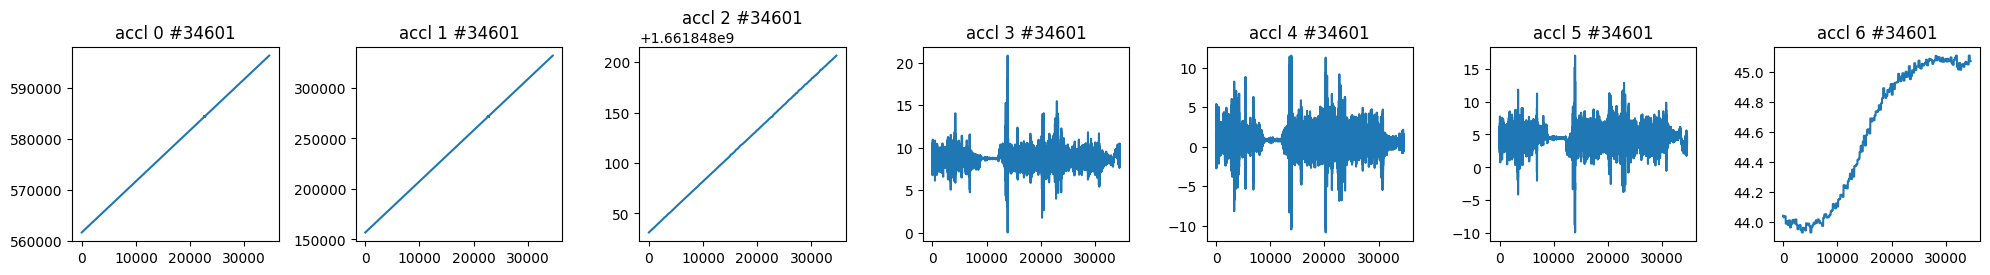

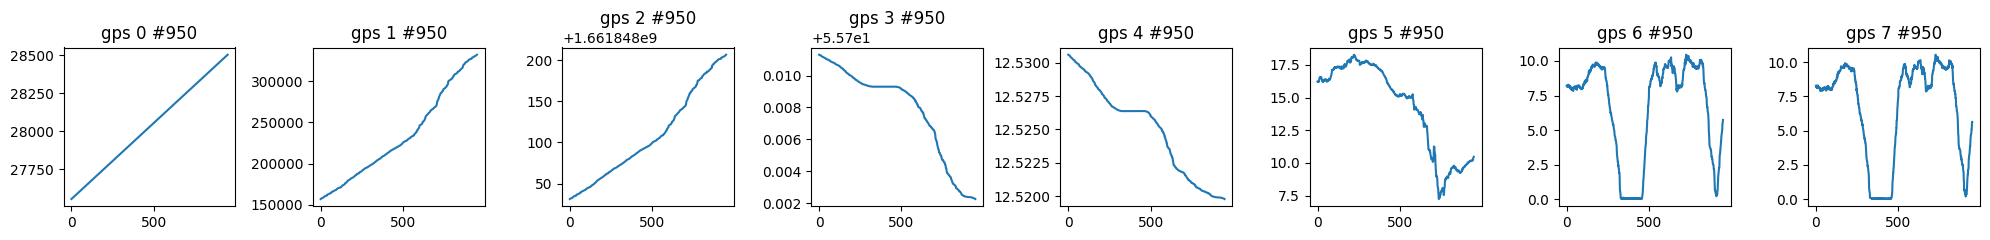

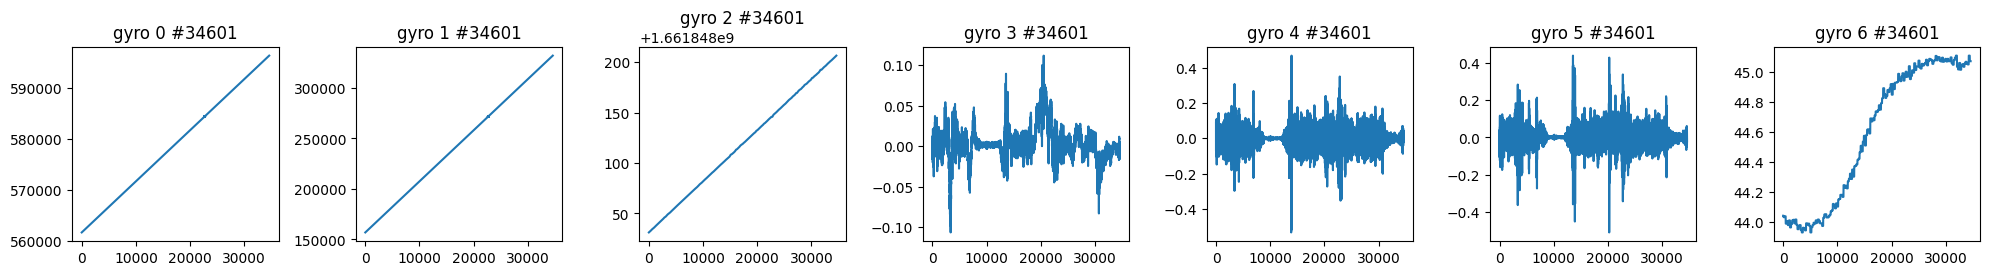

In [9]:
trip = 1
pass_ = 7

for key, autopi_measurements in autopi_hh["gopro"][f"trip_{trip}"][f"pass_{pass_}"].items():
    # Plot one figure for each attribute in data

    fig, ax = plt.subplots(1, autopi_measurements.shape[1], figsize=(20, 20/autopi_measurements.shape[1]))

    for i in range(autopi_measurements.shape[1]):
        ax[i].plot(autopi_measurements[:,i])
        ax[i].set_title(f"{key} {i} #{len(autopi_measurements)}")
    plt.tight_layout()
    plt.show()


In [20]:
class InterpolationClass:

    def interpolate(self, x: np.ndarray, y: np.ndarray, kind="cubic"):
        # Interpolate data to match the time
        match kind:
            case "cubic":
                f = CubicSpline(x, y)
            case _:
                raise ValueError(f"Interpolation method {kind} not supported")
        return f

    def normalise(self, column):
        return (column - column.min()) / (column.max() - column.min())
    
    def start_from_zero(self, column):
        return column - column.min()

class InterpolateP79(InterpolationClass):
    laser_columns = [f" Laser {i} [mm]" for i in range(1, 26)]

    def __init__(self, df: pd.DataFrame, kind="cubic"):
        self.df = df
        self.kind = kind
        self.accumulated_distance = self.start_from_zero(df["Distance [m]"])
        
        self.lasers = self.interpolate(self.accumulated_distance, df[self.laser_columns].iloc[:, ], kind=kind)
        self.lon = self.interpolate(self.accumulated_distance, df[["Lon"]], kind=kind)
        self.lat = self.interpolate(self.accumulated_distance, df[["Lat"]], kind=kind)


class InterpolateAutopiPassGoPro(InterpolationClass):

    def __init__(self, data: dict, kind="cubic"):
        self.data = self.remove_zero_speed_entries(data, threshold=0.1)
        self.kind = kind

        # Calculate the distance of each GPS point
        time = self.data["gps"][:, 2]
        speed = self.data["gps"][:, 6]
        self.accumulated_distance = np.concatenate(([0], np.cumsum(speed[:-1] * np.diff(time))))

        # Interpolate the distance to allign measurements with varying sampling rates
        self.interpolated_distance = self.interpolate(time, self.accumulated_distance, kind=kind)
        
        self.lon = self.interpolate(self.accumulated_distance, self.data["gps"][:, 4], kind=kind)
        self.lat = self.interpolate(self.accumulated_distance, self.data["gps"][:, 3], kind=kind)

        # Interpolate accl data
        accl_accumulated_distance = self.interpolated_distance(self.data["accl"][:, 2])
        accl_unique_mask = np.unique(accl_accumulated_distance, return_index=True)[1]
        self.accl = self.interpolate(accl_accumulated_distance[accl_unique_mask], self.data["accl"][accl_unique_mask, 3:], kind=kind)

        # Interpolate gyro data 
        gyro_accumulated_distance = self.interpolated_distance(self.data["gyro"][:, 2])
        gyro_unique_mask = np.unique(gyro_accumulated_distance, return_index=True)[1]
        self.gyro = self.interpolate(gyro_accumulated_distance[gyro_unique_mask], self.data["gyro"][gyro_unique_mask, 3:], kind=kind)
    
    def remove_zero_speed_entries(self, data, threshold=0.1):
        # Find the ranges in time where the speed is zero
        zero_speed_ranges = []
        start_index = -1
        for i in range(1, len(data["gps"])):
            if data["gps"][i, 6] < threshold:
                if start_index == -1:
                    start_index = i
            else:
                if start_index != -1:
                    zero_speed_ranges.append((data["gps"][start_index, 2], data["gps"][i, 2]))
                    start_index = -1
        
        initial_gps_timestamp = data["gps"][0, 2]
        last_gps_timestamp = data["gps"][-1, 2]
        # Remove the zero speed ranges from the data based on timestamps
        for measurement in data.keys():
            # Remove timestamps which are before initial gps timestamp and after the last gps timestamp
            mask = (data[measurement][:, 2] < initial_gps_timestamp) | (data[measurement][:, 2] > last_gps_timestamp)
            data[measurement] = data[measurement][~mask]
            for start, end in zero_speed_ranges:
                mask = (data[measurement][:, 2] >= start) & (data[measurement][:, 2] <= end)
                data[measurement] = data[measurement][~mask]
        
        return data


class InterpolateAutopiGoPro:

    def __init__(self, data: dict, kind="cubic"):
        self.data = data
        self.kind = kind

        # self.lasers = self.interpolate(data["Distance"], data["Laser"], kind=kind)
        self.passes = {}
        for trip_name, trip in data.items():
            self.passes[trip_name] = {}
            for pass_name, pass_ in trip.items():
                self.passes[trip_name][pass_name] = InterpolateAutopiPassGoPro(pass_, kind=kind)
    
    def __getitem__(self, key):
        return self.passes[key[0]][key[1]]

In [21]:
# Interpolate P79 laser data to match with the corresponding distance measurements
p79_hh_interp = InterpolateP79(deepcopy(cut_p79_hh))

# Interpolate AutoPi data to match with the corresponding time measurements
autopi_hh_interp_gopro = InterpolateAutopiGoPro(deepcopy(autopi_hh['gopro']))

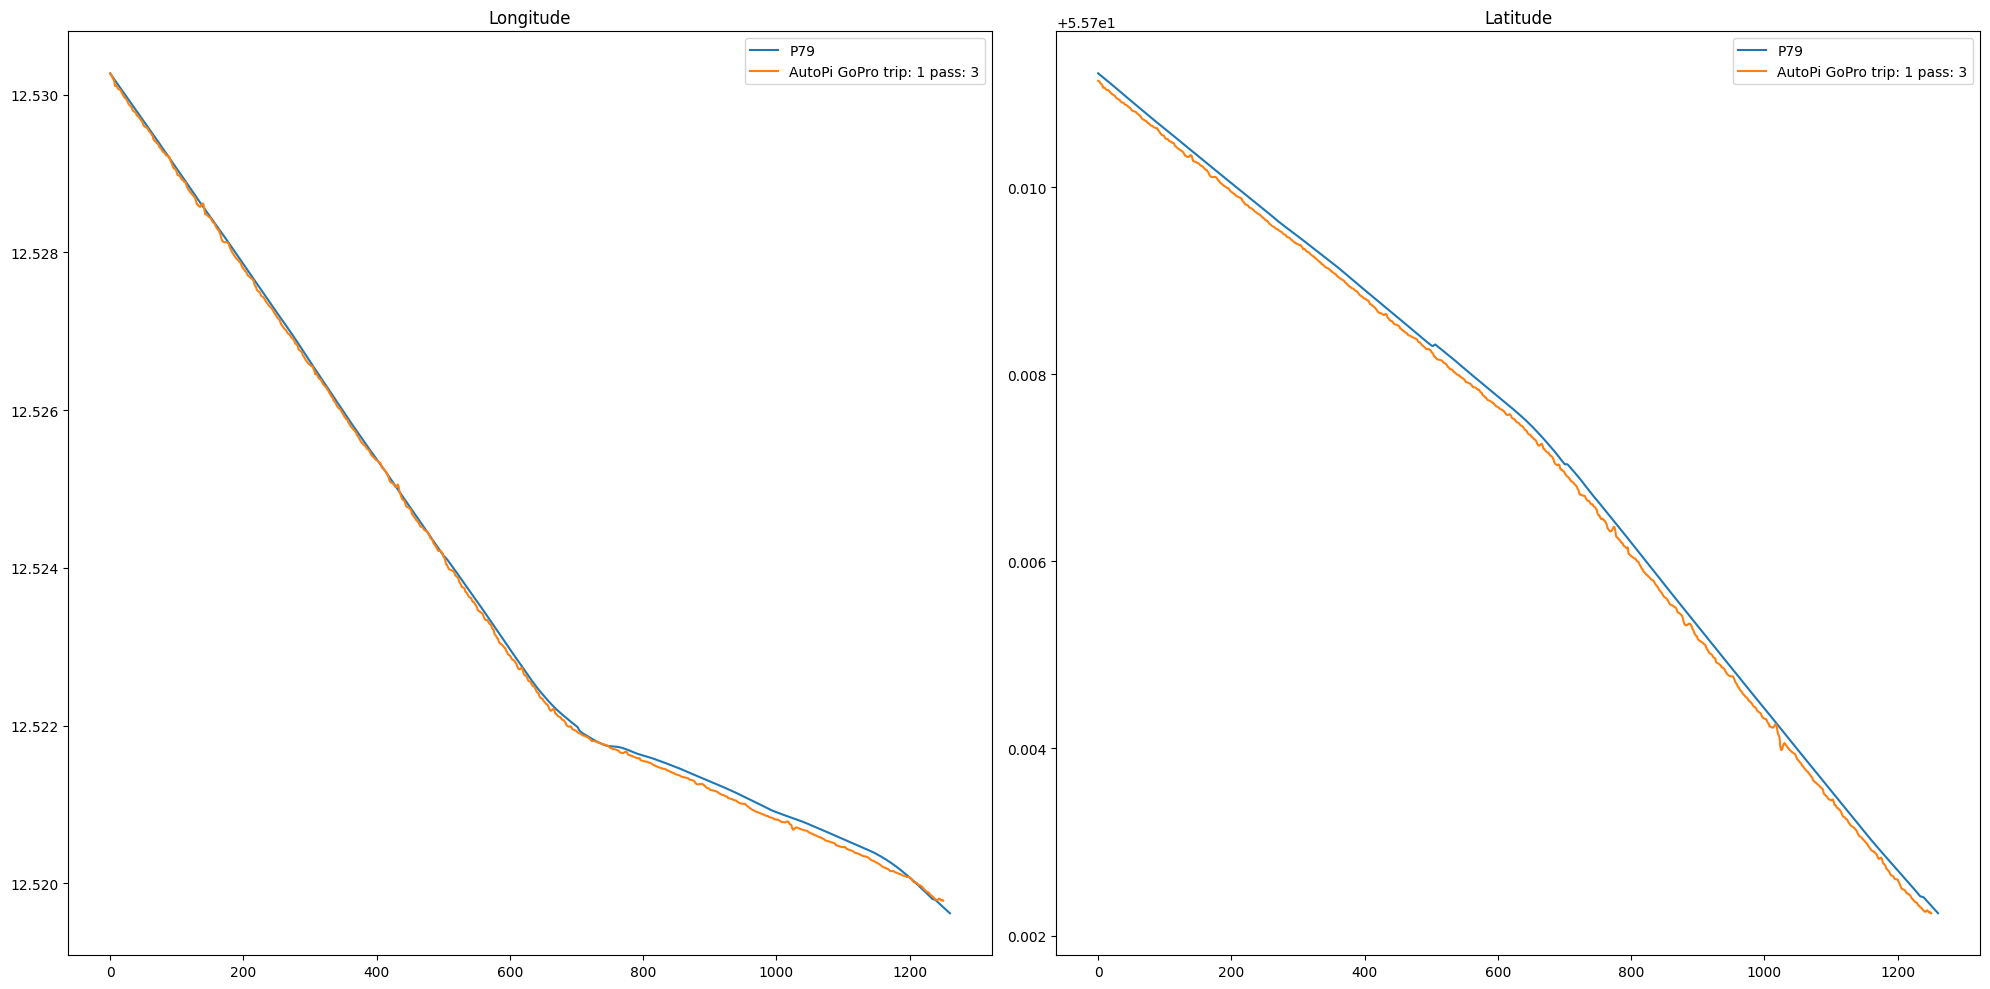

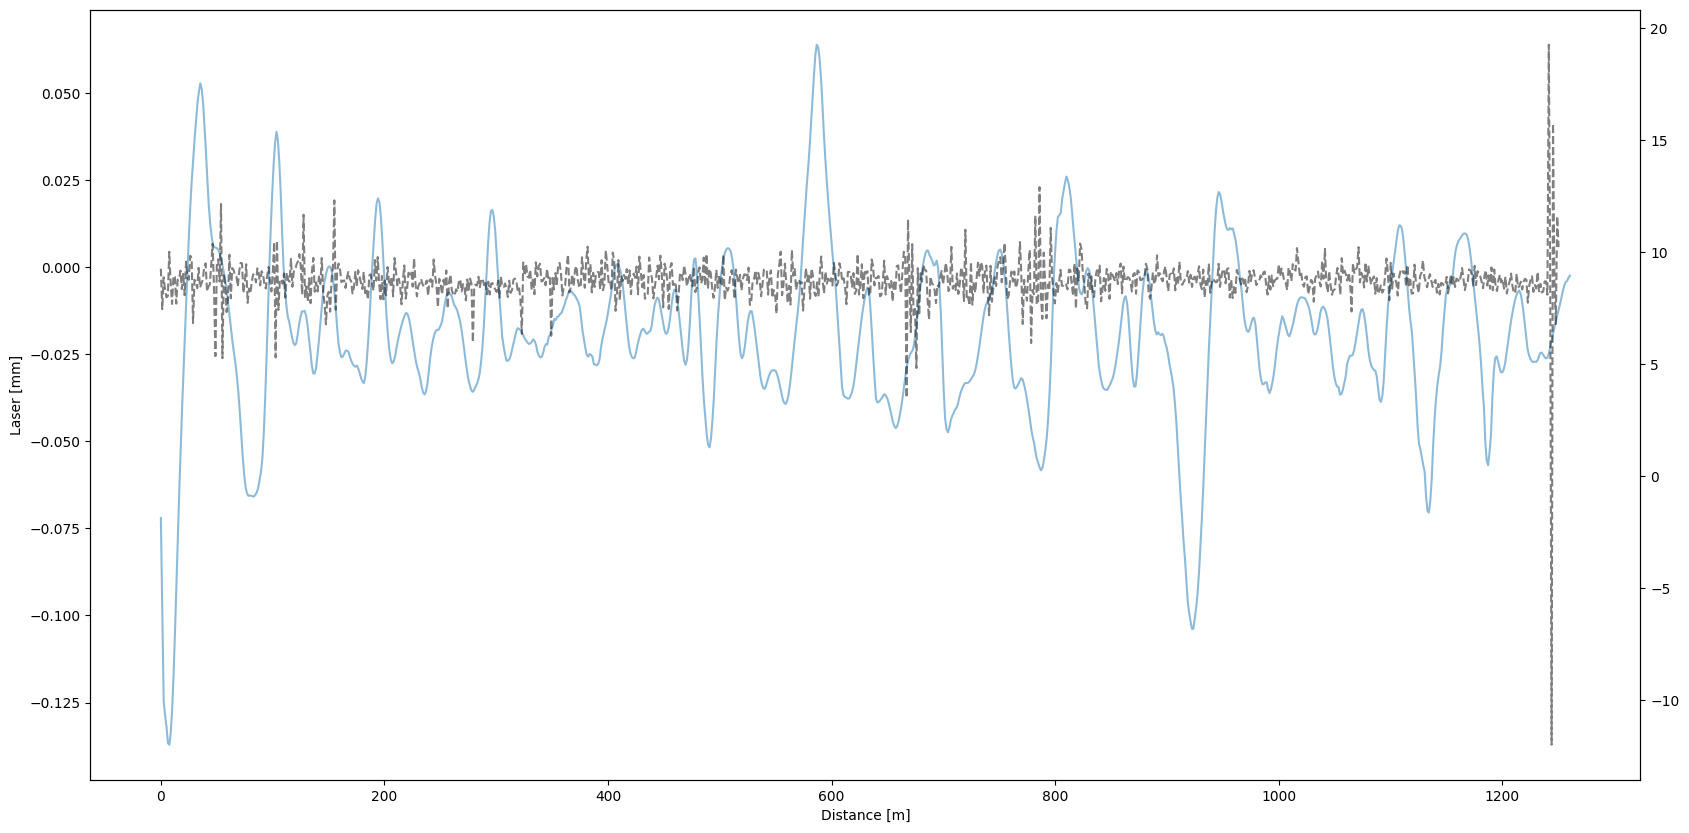

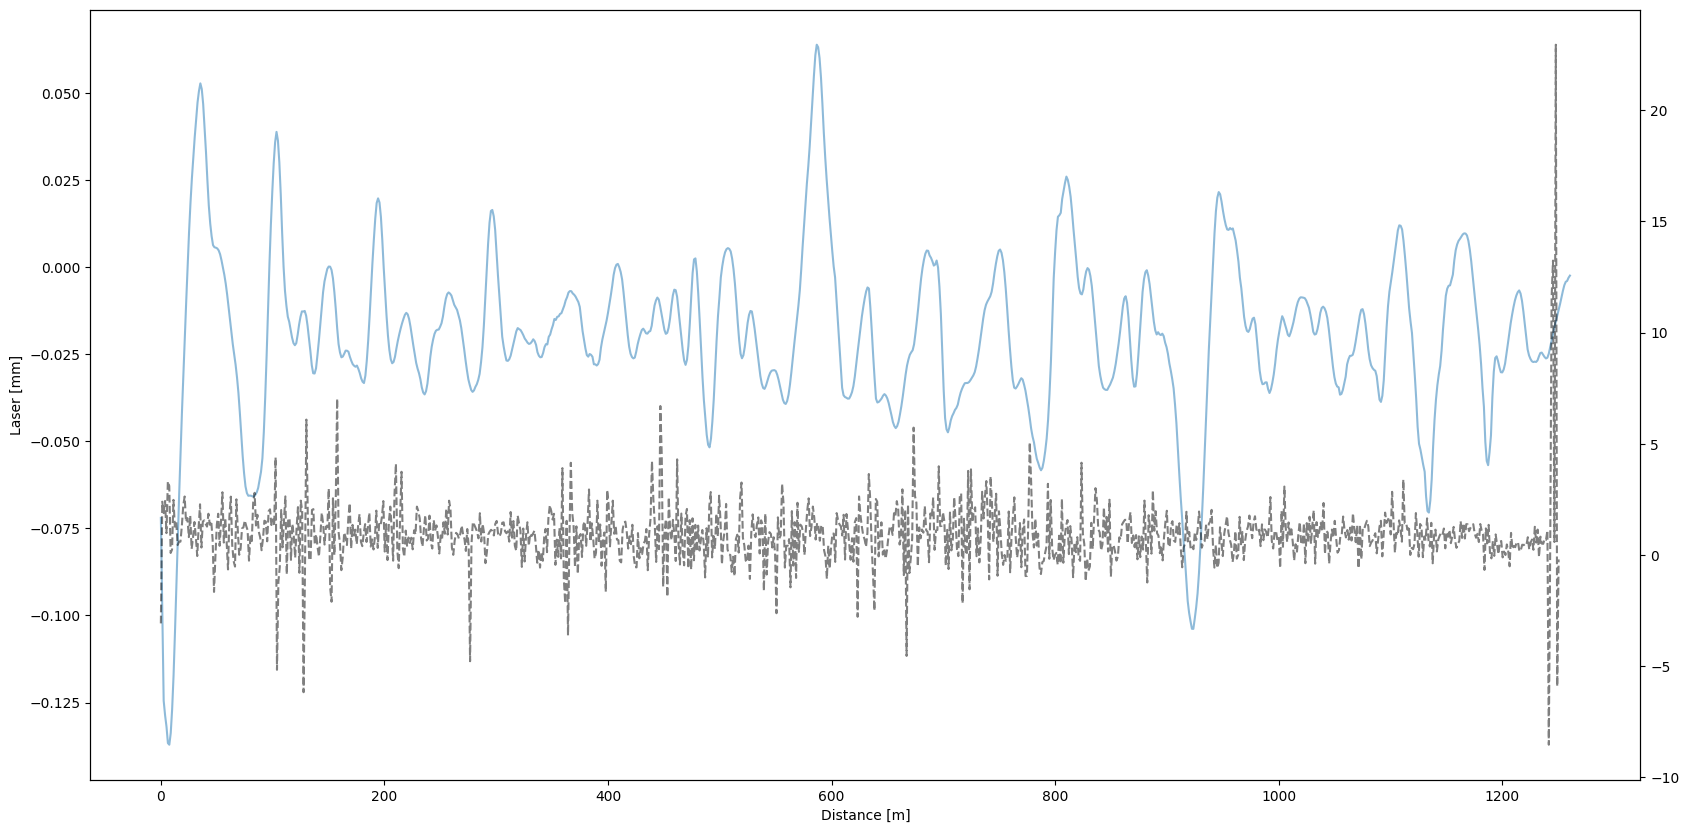

In [81]:
trip_id = 1
pass_id = 3

# Cut p79 data to match the AutoPi data
p79_hh_trip = cut_dataframe_by_indeces(
    p79_hh, *find_best_start_and_end_indeces(
        p79_hh[["Lon", "Lat"]].values,
        autopi_hh["gopro"][f'trip_{trip_id}'][f'pass_{pass_id}']["gps"][:, 4:2:-1]
    )
)

p79_hh_trip_interp = InterpolateP79(deepcopy(p79_hh_trip))



# Plot the interpolated data
s_p79 = np.linspace(0, p79_hh_trip_interp.accumulated_distance.max(), 1000)
s_gopro = np.linspace(0, autopi_hh_interp_gopro[f"trip_{trip_id}", f"pass_{pass_id}"].accumulated_distance.max(), 1000)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.plot(s_p79, p79_hh_trip_interp.lon(s_p79), label="P79")
ax1.plot(s_gopro, autopi_hh_interp_gopro[f"trip_{trip_id}", f"pass_{pass_id}"].lon(s_gopro), label=f"AutoPi GoPro trip: {trip_id} pass: {pass_id}")
# ax1.plot(s_gopro, autopi_hh_interp_gopro[f"trip_{trip_id}", f"pass_{pass_id+1}"].lon(s_gopro), label=f"AutoPi GoPro trip: {trip_id} pass: {pass_id+1}")
ax1.set_title("Longitude")
ax1.legend()

ax2.plot(s_p79, p79_hh_trip_interp.lat(s_p79), label="P79")
ax2.plot(s_gopro, autopi_hh_interp_gopro[f"trip_{trip_id}", f"pass_{pass_id}"].lat(s_gopro), label=f"AutoPi GoPro trip: {trip_id} pass: {pass_id}")
# ax2.plot(s_gopro, autopi_hh_interp_gopro[f"trip_{trip_id}", f"pass_{pass_id+1}"].lat(s_gopro), label=f"AutoPi GoPro trip: {trip_id} pass: {pass_id+1}")
ax2.set_title("Latitude")
ax2.legend()

plt.tight_layout()
plt.show()


# Compare p79 lasers and z axis acceleration from GoPro

for i in range(2):
    fig, ax = plt.subplots(figsize=(20, 10))
    lasers = p79_hh_interp.lasers(s_p79)
    raw_profile = (lasers[:,4] + lasers[:, 20])*0.001/2
    ax.plot(s_p79, np.convolve(raw_profile, np.ones(5)/5, 'same'), alpha=0.5)
    ax2 = ax.twinx()
    ax2.plot(s_gopro, autopi_hh_interp_gopro[f"trip_{trip_id}", f"pass_{pass_id}"].accl(s_gopro)[:, i], '--k', alpha=0.5)
    # ax.legend()
    ax.set_xlabel("Distance [m]")
    ax.set_ylabel("Laser [mm]")
    plt.show()


In [55]:
for name, trip in autopi_hh["GM"].items():
    print(name, trip.keys())

16006 dict_keys(['pass_1', 'pass_11', 'pass_13', 'pass_15', 'pass_17', 'pass_19', 'pass_3', 'pass_5', 'pass_7', 'pass_9'])
16008 dict_keys(['pass_1', 'pass_11', 'pass_13', 'pass_15', 'pass_17', 'pass_3', 'pass_5', 'pass_7', 'pass_9'])
16009 dict_keys(['pass_1', 'pass_11', 'pass_13', 'pass_3', 'pass_5', 'pass_7', 'pass_9'])
16010 dict_keys(['pass_1', 'pass_11', 'pass_13', 'pass_3', 'pass_5', 'pass_7', 'pass_9'])
16011 dict_keys(['pass_1', 'pass_11', 'pass_13', 'pass_3', 'pass_5', 'pass_7', 'pass_9'])


In [56]:
for name, trip in autopi_hh["gopro"].items():
    print(name, trip.keys())

trip_1 dict_keys(['pass_1', 'pass_3', 'pass_5', 'pass_7', 'pass_9'])
trip_2 dict_keys(['pass_1', 'pass_2', 'pass_3', 'pass_4', 'pass_5', 'pass_6', 'pass_7', 'pass_8'])


In [66]:
matchings = {}


for g_trip_name, g_trip in autopi_hh["gopro"].items():
    for g_pass_name, g_pass in g_trip.items():
        start_time = g_pass["gps"][0, 2]
        end_time = g_pass["gps"][-1, 2]
        best_error = np.inf
        # Find GM trip that matches the start and end time
        for gm_trip_name, gm_trip in autopi_hh["GM"].items():
            for gm_pass_name, gm_pass in gm_trip.items():
                gm_start_time = gm_pass["gps"][0, 0]
                gm_end_time = gm_pass["gps"][-1, 0]
                error = np.abs(start_time - gm_start_time) + np.abs(end_time - gm_end_time)
                if error < best_error:
                    best_error = error
                    best_match = (gm_trip_name, gm_pass_name, error)
        matchings[(g_trip_name, g_pass_name)] = best_match


In [67]:
matchings

{('trip_1', 'pass_1'): ('16010', 'pass_1', 27.011000394821167),
 ('trip_1', 'pass_3'): ('16010', 'pass_3', 1.0249998569488525),
 ('trip_1', 'pass_5'): ('16009', 'pass_5', 8.408999919891357),
 ('trip_1', 'pass_7'): ('16011', 'pass_7', 5.31000018119812),
 ('trip_1', 'pass_9'): ('16011', 'pass_9', 50.52499985694885),
 ('trip_2', 'pass_1'): ('16009', 'pass_1', 10.67799973487854),
 ('trip_2', 'pass_2'): ('16009', 'pass_1', 10.67799973487854),
 ('trip_2', 'pass_3'): ('16010', 'pass_3', 4.502999544143677),
 ('trip_2', 'pass_4'): ('16010', 'pass_3', 4.502999544143677),
 ('trip_2', 'pass_5'): ('16009', 'pass_5', 5.016000270843506),
 ('trip_2', 'pass_6'): ('16009', 'pass_5', 5.016000270843506),
 ('trip_2', 'pass_7'): ('16009', 'pass_7', 5.200000286102295),
 ('trip_2', 'pass_8'): ('16009', 'pass_7', 5.200000286102295)}

In [52]:
autopi_hh["gopro"][f"trip_{trip_id}"][f"pass_{pass_id}"]["accl"][:, 3:].mean(axis=0)

array([ 8.72712291,  0.86488851,  4.46809261, 44.59092053])